In [1]:
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
image_path = "../img/billie.jpg"
image = Image.open(image_path)
width, height = image.size

In [3]:
image_array = np.array(image, dtype=np.uint8)

In [4]:
kernel_code = """
#define BLUR_SIZE 100
__global__
void blurKernel(unsigned char* in, unsigned char* out, int width, int height) {
    int Col = blockIdx.x * blockDim.x + threadIdx.x;
    int Row = blockIdx.y * blockDim.y + threadIdx.y;

    if(Col < width && Row < height)
    {
        int pixVal = 0;
        int pixels = 0;
        for (int blurRow = -BLUR_SIZE; blurRow < BLUR_SIZE+1; ++blurRow)
        {
            for (int blurCol = -BLUR_SIZE; blurCol < BLUR_SIZE+1; ++blurCol)
            {
                int curRow = Row + blurRow;
                int curCol = Col + blurCol;
                // Valid pixel in the image?
                if(curRow > -1 && curRow < height && curCol > -1 && curCol < width)
                {
                    pixVal += in[curRow * width + curCol];
                    pixels++; 
                }
            }
        }
        out[Row*width+Col] = (unsigned char)(pixVal/pixels);
    }
}
"""

In [5]:
kernel_code = """
#define KERNEL_SIZE 100
#define CHANNELS 3
__global__ void blurKernel(unsigned char *image_in, unsigned char *image_out, int width, int height) {
    int Col = blockIdx.x * blockDim.x + threadIdx.x;
    int Row = blockIdx.y * blockDim.y + threadIdx.y;

    if (Col < width && Row < height) {
        int outOffset = (Row * width + Col) * CHANNELS;
        float3 sum = make_float3(0.0f, 0.0f, 0.0f);
        int validPixels = 0;

        for (int blurRow = -KERNEL_SIZE; blurRow <= KERNEL_SIZE; ++blurRow) {
            for (int blurCol = -KERNEL_SIZE; blurCol <= KERNEL_SIZE; ++blurCol) {
                int curCol = Col + blurCol;
                int curRow = Row + blurRow;
                if (curCol >= 0 && curCol < width && curRow >= 0 && curRow < height) {
                    int inOffset = (curRow * width + curCol) * CHANNELS;
                    sum.x += image_in[inOffset];
                    sum.y += image_in[inOffset + 1];
                    sum.z += image_in[inOffset + 2];
                    validPixels++;
                }
            }
        }

        image_out[outOffset] = sum.x / validPixels;
        image_out[outOffset + 1] = sum.y / validPixels;
        image_out[outOffset + 2] = sum.z / validPixels;
    }
}
"""

In [6]:
module = SourceModule(kernel_code)
blur_kernel = module.get_function("blurKernel")

In [7]:
image_in_gpu = cuda.mem_alloc(image_array.nbytes)
image_out_gpu = cuda.mem_alloc(image_array.nbytes)

In [8]:
image_array.shape

(4320, 7680, 3)

In [9]:
cuda.memcpy_htod(image_in_gpu, image_array)

In [10]:
block_dim = (16,16,1)
grid_dim = (
    (width + block_dim[0] - 1) // block_dim[0],
    (height + block_dim[1] - 1) // block_dim[1]
)

In [11]:
blur_kernel(
    image_in_gpu, image_out_gpu,
    np.int32(width), np.int32(height),
    block=block_dim,
    grid=grid_dim
)

In [12]:
output_array = np.empty_like(image_array)
cuda.memcpy_dtoh(output_array, image_out_gpu)

In [13]:
output_image = Image.fromarray(output_array)

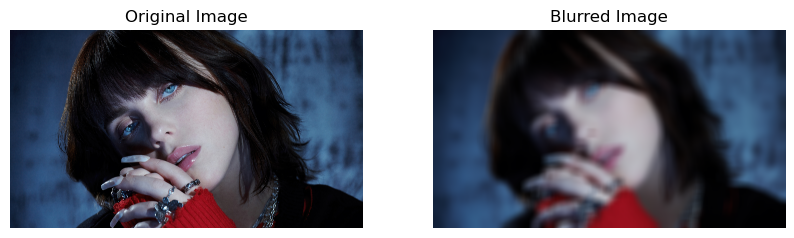

In [14]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Blurred Image")
plt.imshow(output_image)
plt.axis("off")

plt.show()

In [15]:
image_array.shape

(4320, 7680, 3)

In [16]:
del image_in_gpu
del image_out_gpu